# Multi-layer perceptrons (MLP) PINN
from: Respecting causality is all you need for training physics-informed neural networks, Wang 2022 [https://doi.org/10.48550/arXiv.2203.07404]

Modified loss function that includes weights for explicitly account for the missig casula structure of PINNs. The loss function is defined as: $$\mathcal{L}_r(\theta) = \frac{1}{N_t} \sum^{N_t}_{i=1} \exp(-\epsilon \sum^{i-1}_{k=1} \mathcal{L}_r(t_k, \theta)) \mathcal{L}_r(t_i, \theta)$$ where: $$\mathcal{L}_r(t, \theta) = \frac{1}{N_x} \sum^{N_x}_{j=1} |\frac{\partial u_\theta}{\partial t} (t, x_j) + \mathcal{N}[u_\theta](t,x_j)|^2$$

In [1]:
import torch.nn as nn
import torch.optim as optim
from torch import vmap
from torch.func import jacrev
import torch

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [2]:
def ODE_1(t, y): # Exponential decay
    # y: R^1, lambda: 0.1
    y = torch.tensor(y, dtype=torch.float32).to(device)
    return -0.1 * y

ODE_1_y0 = torch.tensor([2.0]).to(device)

def ODE_2(t, y): # Van der Pol Oscillator
    # y: R^2, mu: 2
    if not isinstance(y, torch.Tensor):
        y = torch.tensor(y, dtype=torch.float32).to(device)
    
    x = y[0]
    dy = y[1]
    # Parameters
    omega = 1.0
    zeta = 0.5
    
    dydt = torch.stack([dy, -omega**2 * x - 2 * zeta * omega * dy]).to(device)
    return dydt

ODE_2_y0 = torch.tensor([2.0, 0.0]).to(device)

In [3]:
class LinearNN(nn.Module):
    def __init__(
        self,
        num_inputs,
        num_layers,
        num_neurons,
        num_outputs,
        act: nn.Module = nn.Tanh(),
    ) -> None:
        """Basic neural network architecture with linear layers
        
        Args:
            num_inputs (int, optional): the dimensionality of the input tensor
            num_layers (int, optional): the number of hidden layers
            num_neurons (int, optional): the number of neurons for each hidden layer
            act (nn.Module, optional): the non-linear activation function to use for stitching
                linear layers togeter
        """
        super().__init__()
        
        self.num_inputs = num_inputs
        self.num_neurons = num_neurons
        self.num_layers = num_layers

        layers = []

        # input layer
        layers.append(nn.Linear(self.num_inputs, num_neurons))

        # hidden layers with linear layer and activation
        for _ in range(num_layers):
            layers.extend([nn.Linear(num_neurons, num_neurons), act])

        # output layer
        layers.append(nn.Linear(num_neurons, num_outputs))

        # build the network
        self.network = nn.Sequential(*layers)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.network(x.reshape(-1, 1)).squeeze()

In [4]:
model = LinearNN(1, 4, 64, 2).to(device)

# Define the Jacobian function for a single input
def jacobian_fn(x):
    return jacrev(model)(x)

# Use vmap to compute Jacobians for each element in the batch
batched_jacobian_fn = vmap(jacobian_fn)

In [5]:
ODE_batch = vmap(ODE_2, in_dims=0)

In [6]:
torch.tensor([1.0, 2.0, 3.0]).view(1, -1).shape


torch.Size([1, 3])

In [7]:
def loss_fn(t: torch.Tensor):
    # BOUNDARY LOSS
    y_0 = model(torch.tensor([0.0], requires_grad=True).to(device))
    
    boundary = y_0 - ODE_2_y0
    
    # INTERIOR LOSS
    # NN grads
    y = model(t)
    jacobians = batched_jacobian_fn(t)
    dydt = jacobians.squeeze(-1)
    # ODE actual grads
    ode_grads = ODE_batch(t, y)
    interior = dydt - ode_grads
    
    # Combine losses
    loss_t = torch.cat([boundary.view(1, -1), interior])
    loss_t = (loss_t**2)
    
    # weights of the loss
    epsilon = 1
    w = torch.exp(- epsilon * (torch.cumsum(loss_t.detach(), dim=0) - loss_t.detach()))
    
    loss = torch.mean(w * loss_t)
    
    return loss, w
    

In [8]:
batch_size = 128  # number of colocation points to sample in the domain
num_iter = 50000  # maximum number of iterations
learning_rate = 1e-3  # learning rate
weight_decay = 1e-5  # weight decay
T = 10  # final time

epsilon_list = [1e-2, 1e-1, 1e0, 1e1, 1e2]
delta = 0.99

optimzier = optim.Adam(model.parameters(), lr=learning_rate)

for epsilon in epsilon_list:
    for i in range(num_iter):
        t = (torch.rand(batch_size) * T).to(device)
        t, _ = torch.sort(t)
        t.requires_grad_(True)
        
        loss, w = loss_fn(t)
        loss.backward()
        optimzier.step()
        optimzier.zero_grad()
        min_w = torch.min(w)
        if i % 10 == 0:
            print(f"Iteration {i}, Loss: {loss.item()}, Min w: {min_w.item()}")
        
        if min_w > delta:
            print(f"Early break at iteration {i} --------------------------------")
            break

/home/vedo/miniconda3/envs/thesis/lib/python3.12/site-packages/torch/autograd/graph.py:744: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at /home/conda/feedstock_root/build_artifacts/libtorch_1718580740865/work/aten/src/ATen/cuda/CublasHandlePool.cpp:135.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Iteration 0, Loss: 0.03483295068144798, Min w: 0.02305794693529606
Iteration 10, Loss: 0.02768576517701149, Min w: 0.001655398984439671
Iteration 20, Loss: 0.02101810835301876, Min w: 6.58140697851195e-06
Iteration 30, Loss: 0.01726057380437851, Min w: 2.4727404152047328e-11
Iteration 40, Loss: 0.01526185218244791, Min w: 3.336036284910857e-17
Iteration 50, Loss: 0.014965075068175793, Min w: 2.6439170297543058e-11
Iteration 60, Loss: 0.010865572839975357, Min w: 1.3033510185778141e-05
Iteration 70, Loss: 0.011505861766636372, Min w: 0.12316683679819107
Iteration 80, Loss: 0.008193496614694595, Min w: 0.38571563363075256
Iteration 90, Loss: 0.006846609525382519, Min w: 0.5078372359275818
Iteration 100, Loss: 0.006334792822599411, Min w: 0.5582371950149536
Iteration 110, Loss: 0.004258521366864443, Min w: 0.6482829451560974
Iteration 120, Loss: 0.004446012899279594, Min w: 0.7076735496520996
Iteration 130, Loss: 0.004574665334075689, Min w: 0.6486214399337769
Iteration 140, Loss: 0.00253

KeyboardInterrupt: 

In [37]:
import numpy as np
import matplotlib.pyplot as plt

In [38]:
# Solve the ODE system numerically
from scipy.integrate import solve_ivp

In [39]:
def ODE_1_np(t, y):
    dydt = ODE_1(t, y)
    return dydt.cpu().numpy()


def ODE_2_np(t,y):
    dydt = ODE_2(t, y)
    return dydt.cpu().numpy()

In [40]:
sol = solve_ivp(ODE_2_np, (0, T), ODE_2_y0.cpu().numpy(), method='RK45', t_eval=np.linspace(0, T, 100))

In [41]:
t = torch.linspace(0, T, 100).view(-1, 1).to(device)

t_np = t.cpu().detach().numpy()
y_pred_np = model(t).cpu().detach().numpy()


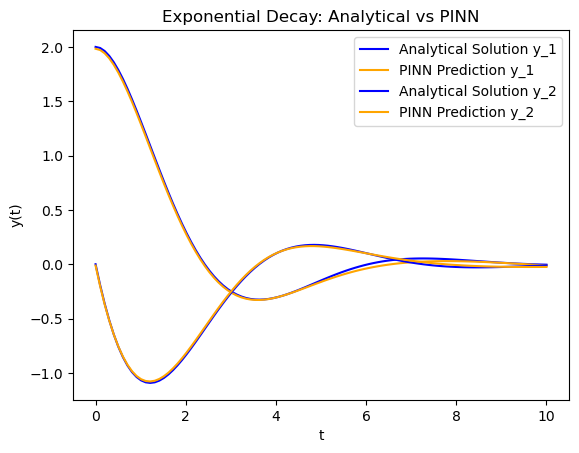

In [42]:
num_y = y_pred_np.shape[1]
for i in range(num_y):
    plt.plot(sol.t, sol.y.T[:, i], color='blue', label=f'Analytical Solution y_{i+1}')
    plt.plot(t_np, y_pred_np[:, i], color='orange', label=f'PINN Prediction y_{i+1}')

plt.xlabel('t')
plt.ylabel('y(t)')
plt.legend()
plt.title('Exponential Decay: Analytical vs PINN')
plt.show()